In [674]:
import csv
import requests
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import matplotlib.patches as patches
import matplotlib.lines as lines

plt.close('all')

In [688]:
CSV_URL = 'https://covidtracking.com/api/v1/states/daily.csv'

with requests.Session() as s:
    download = s.get(CSV_URL)
    download
    decoded_content = download.content.decode('utf-8')
    cr = pd.read_csv(StringIO(decoded_content))
    df = pd.DataFrame(cr)   

In [689]:
date = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
df = pd.DataFrame({'date':date, 'state':df['state'], 'positiveIncrease':df['positiveIncrease']})

stateNames = ['WA', 'ID', 'MT', 'ND', 'MN','WI','MI','NY','VT', 'NH','ME',
             'OR','WY', 'SD', 'IA', 'IL', 'IN', 'OH', 'PA', 'MA', 'RI', 'CT', 'NJ',
             'DE', 'MD', 'DC', 'CA', 'NV', 'UT', 'CO', 'NE', 'MO', 'KS', 'OK', 'NM', 
              'AZ', 'TX', 'LA', 'AR', 'TN', 'MS', 'AL', 'KY', 'WV', 'VA', 'NC',
             'SC', 'GA', 'FL', 'AK', 'HI']
dfstates = []
len(stateNames)

51

In [690]:
# I'm sure there's a cleaner way to do this...

for name in stateNames:
    sel = df[(df['state']==name)]
    sel.index=sel['date']
    dfstates.insert(len(dfstates), sel)
s = 'positiveIncrease'
dfgroup = pd.DataFrame()

for d in dfstates:
    dfgroup[d['state'][0]] = d[s]

dfgroup.head()

,WA,ID,MT,ND,MN,WI,MI,NY,VT,NH,...,AL,KY,WV,VA,NC,SC,GA,FL,AK,HI
date,,,,,,,,,,,,,,,,,,,,,
2020-07-04,627,401.0,39.0,57.0,0.0,776.0,406.0,726.0,2.0,35.0,...,997.0,0.0,15.0,716.0,1413.0,1854.0,2826.0,11458.0,48.0,29.0
2020-07-03,716,223.0,45.0,65.0,414.0,622.0,497.0,918.0,9.0,20.0,...,1754.0,297.0,73.0,658.0,2099.0,1831.0,2784.0,9488.0,46.0,20.0
2020-07-02,611,253.0,67.0,42.0,494.0,584.0,589.0,875.0,17.0,20.0,...,1149.0,237.0,121.0,532.0,1629.0,1782.0,3472.0,10109.0,39.0,9.0
2020-07-01,571,365.0,49.0,39.0,413.0,563.0,361.0,625.0,2.0,22.0,...,917.0,218.0,27.0,416.0,1843.0,1520.0,2946.0,6563.0,38.0,17.0
2020-06-30,501,433.0,48.0,37.0,442.0,629.0,505.0,524.0,0.0,0.0,...,870.0,277.0,35.0,598.0,1186.0,1755.0,1874.0,6093.0,36.0,1.0


In [764]:
#Define color pallete

redBar = '#ECCFC2'
twoWeeksRisingColor = '#F0EBD8'
threeWeeksIncreaseColor = '#F2DFAE'
sevenDayDecreaseColor = '#D8F0DF'
borderColor = "#E1DDBF"
fourWeeksIncreaseColor = '#EBDBD1'

In [765]:
def formatBorder(ax):
    for spineName in ax.spines:
        ax.spines[spineName].set_color(borderColor)
        ax.spines[spineName].set_linewidth(2)

In [766]:
def sumRange(L,a,b):                                                                                                                                                                                                
    sum = 0                                                                                                                                                                                                         
    for i in range(a,b+1,1):                                                                                                                                                                                        
        sum += L[i]                                                                                                                                                                                                  
    return sum      

In [767]:
def consecutiveWeeksIncreased(state):
    weeks = 0
    prev = 999999
    for week in range(10):
        thisWeekSum = sumRange(state, weeks * 7, weeks * 7 + 8)
        if thisWeekSum <= prev:
            prev = thisWeekSum
            weeks += 1
        else:
            return weeks
    return weeks

In [768]:
state = dfgroup['WA']
week = 0
weekSum = sumRange(state, week * 7, week * 7 + 8)
weekSum

4909

In [769]:
week = 1
weekSum = sumRange(state, week * 7, week * 7 + 8)
weekSum

2280

In [770]:
def do_plot(ax, name):
    color = 'C'+str(dfgroup.columns.get_loc(name))
    ax.plot(dfgroup[name], color=(color), linewidth=1)
    ax.set_xlabel('')
    ax.grid(False)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(name,horizontalalignment='left', color=(color), fontweight="bold", fontsize=12, x=0.025, y=.75)
    formatBorder(ax)
    weeksClimbing = consecutiveWeeksIncreased(dfgroup[name])
    if(weeksClimbing >= 4):
        ax.set_facecolor(fourWeeksIncreaseColor)
    else :
        if(weeksClimbing >=3):
            ax.set_facecolor(threeWeeksIncreaseColor)
        else:
            if(weeksClimbing >= 2):
                ax.set_facecolor(twoWeeksRisingColor)
    ax.axhline(y=100, color='r', linestyle='-', linewidth=.2)
    #ax.annotate(s= str(weeksClimbing), xy=(0.1, 0.1), xycoords='axes fraction')

In [771]:
def add_state(figure, stateName, grid):
    state = figure.add_subplot(grid)
    do_plot(state, stateName)
    return state

In [772]:
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
dt_string = "Last updated " + dt_string

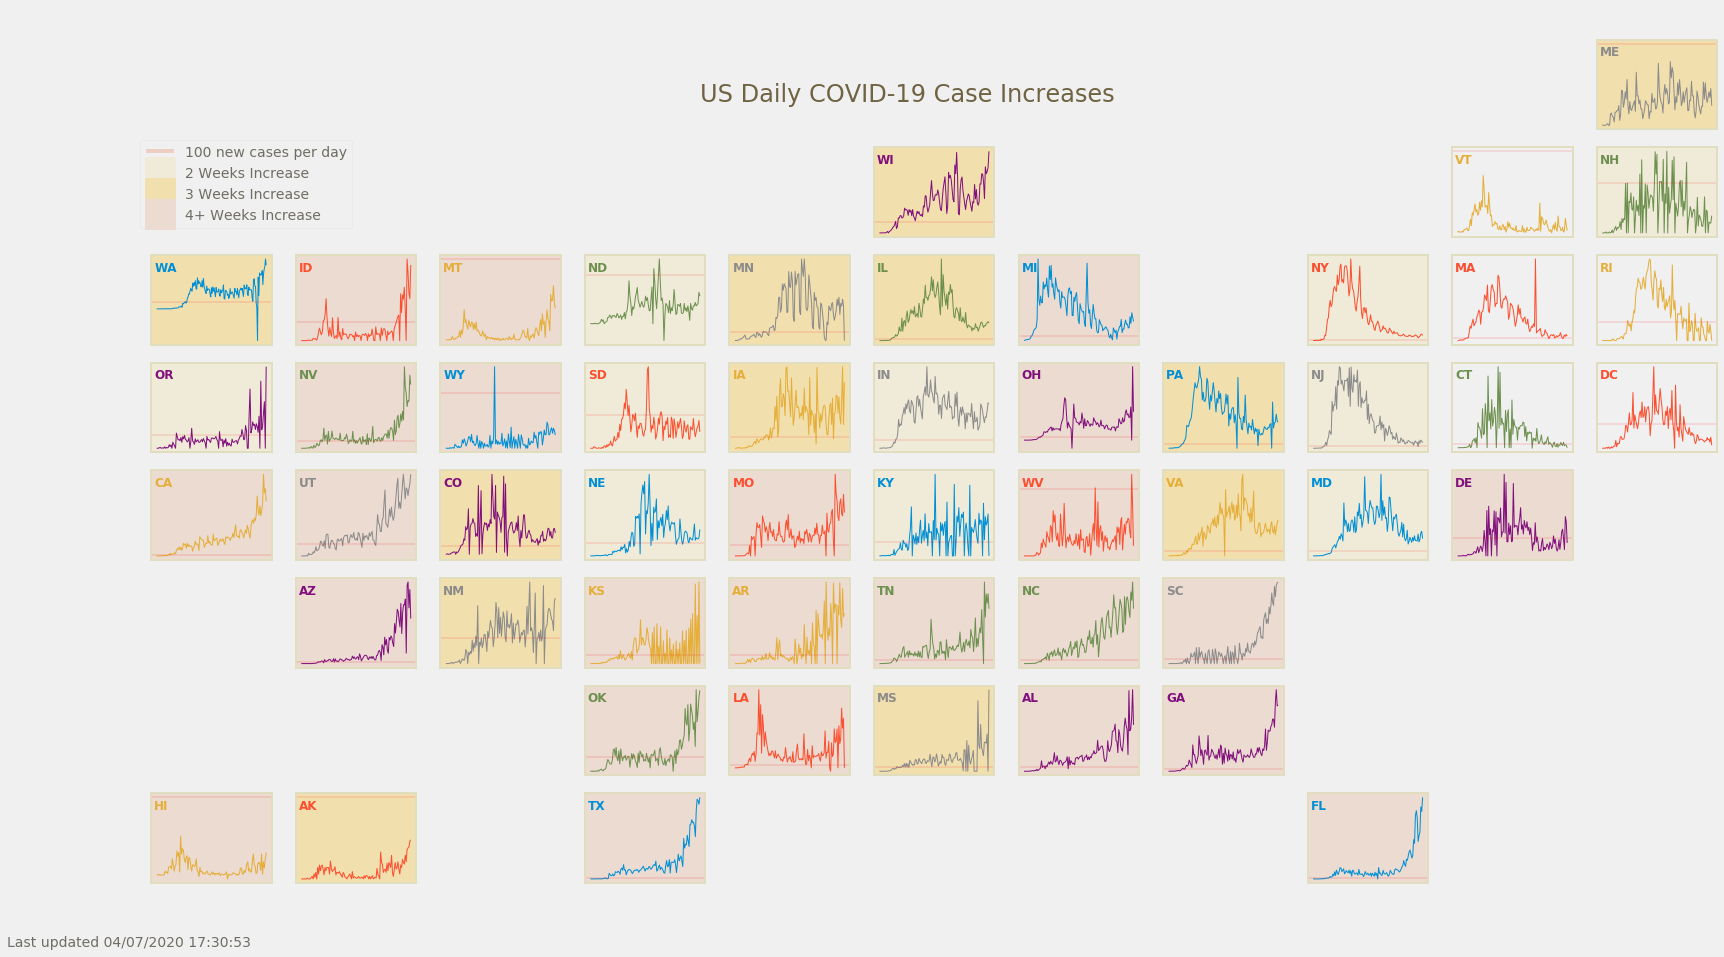

In [782]:
plt.style.use('fivethirtyeight')

g = gridspec.GridSpec(11, 11)

fig = plt.figure(figsize=(25,20))
titleColor = '#706343'
labelColor = '#706D65'
fig.suptitle('US Daily COVID-19 Case Increases', y=0.85, fontsize=24, color=titleColor)
fig.text(x=0, y=.25, s=dt_string, color = labelColor)

x = .1
y =.75


##### Legend
redline = mlines.Line2D([], [], color=redBar, marker='', markersize=15, label='100 new cases per day')
twoWeeksIncrease = mlines.Line2D([],[], color = twoWeeksRisingColor, marker='s',markersize=30, label='2 Weeks Increase')
threeWeeksIncrease = mlines.Line2D([],[], color = threeWeeksIncreaseColor, marker='s',markersize=30, label='3 Weeks Increase')
fourWeeksIncrease = mlines.Line2D([],[], color = fourWeeksIncreaseColor, marker='s',markersize=30, label='4+ Weeks Increase')

legend = fig.legend(handles=[redline, twoWeeksIncrease, threeWeeksIncrease, fourWeeksIncrease], loc='upper left',borderaxespad=10, framealpha=.3)

for t in legend.get_texts():
    t.set_color(labelColor)
    
#####

#TODO : convert to column/row iteration and pass string lists
add_state(fig, 'WA', g[2, 0])#  Washington
add_state(fig, 'OR', g[3, 0])#  Oregon
add_state(fig, 'CA', g[4, 0])#  California
add_state(fig, 'HI', g[7, 0])#  Hawaii

add_state(fig, 'ID', g[2, 1])#  Idaho
add_state(fig, 'NV', g[3, 1])#  Nevada
add_state(fig, 'UT', g[4, 1])#  Utah
add_state(fig, 'AZ', g[5, 1])#  Arizona
add_state(fig, 'AK', g[7, 1])#  Alaska

add_state(fig, 'MT', g[2, 2])#  Montana
add_state(fig, 'WY', g[3, 2])#  Wyoming
add_state(fig, 'CO', g[4, 2])#  Colorado
add_state(fig, 'NM', g[5, 2])#  New Mexico

add_state(fig, 'ND', g[2, 3])#  North Dakota
add_state(fig, 'SD', g[3, 3])#  South Dakota
add_state(fig, 'NE', g[4, 3])#  Nebraska
add_state(fig, 'KS', g[5, 3])#  Kansas
add_state(fig, 'OK', g[6, 3])#  Oklahoma
add_state(fig, 'TX', g[7, 3])#  Texas

add_state(fig, 'MN', g[2, 4])#  Minnesota
add_state(fig, 'IA', g[3, 4])#  Iowa
add_state(fig, 'MO', g[4, 4])#  Missouri
add_state(fig, 'AR', g[5, 4])#  Arkansas
add_state(fig, 'LA', g[6, 4])#  Louisianna

add_state(fig, 'WI', g[1, 5])#  Wisconsin
add_state(fig, 'IL', g[2, 5])#  Illinois
add_state(fig, 'IN', g[3, 5])#  Indianna
add_state(fig, 'KY', g[4, 5])#  Kentucky
add_state(fig, 'TN', g[5, 5])#  Tennessee
add_state(fig, 'MS', g[6, 5])#  Mississippi

add_state(fig, 'MI', g[2, 6])#  Michigan
add_state(fig, 'OH', g[3, 6])#  Ohio
add_state(fig, 'WV', g[4, 6])#  West Virginia
add_state(fig, 'NC', g[5, 6])#  North Carolina
add_state(fig, 'AL', g[6, 6])#  Alabama

add_state(fig, 'PA', g[3, 7])#  Pennsylvania
add_state(fig, 'VA', g[4, 7])#  Virginia
add_state(fig, 'SC', g[5, 7])#  South Carolina
add_state(fig, 'GA', g[6, 7])#  Georgia

add_state(fig, 'NY', g[2, 8])#  New York
add_state(fig, 'NJ', g[3, 8])#  New Jersey
add_state(fig, 'MD', g[4, 8])#  Maryland
add_state(fig, 'FL', g[7, 8])#  Florida

add_state(fig, 'VT', g[1, 9])#  Vermont
add_state(fig, 'MA', g[2, 9])#  Massachusetts
add_state(fig, 'CT', g[3, 9])#  Connecticut
add_state(fig, 'DE', g[4, 9])#  Deleware

add_state(fig, 'ME', g[0, 10])# Maine
add_state(fig, 'NH', g[1, 10])# New Hampshire
add_state(fig, 'RI', g[2, 10])# Rhode Island
add_state(fig, 'DC', g[3, 10])# DC
